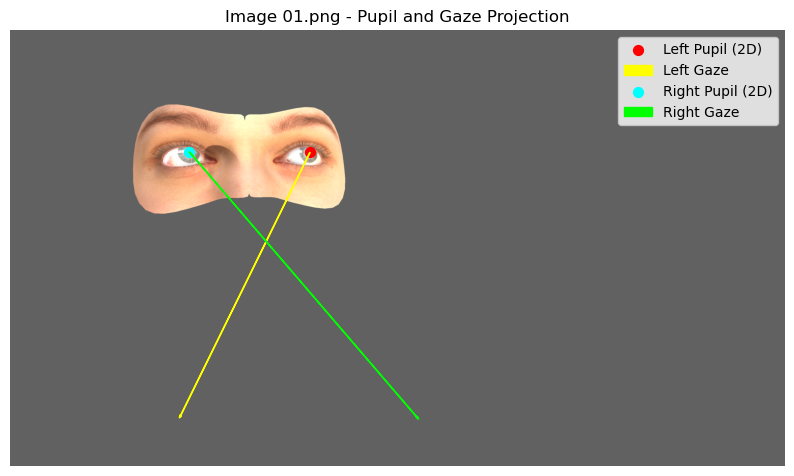

Image: 01.png
Left Pupil 3D (calibrated): [  3.5561678  -3.7416523 -10.98276  ]
Headpose Gaze Vector (raw): [ 22.5513    -8.118401 -42.251   ]
Right Pupil 3D (calibrated): [ -2.8925707  -3.781768  -11.008488 ]
-----


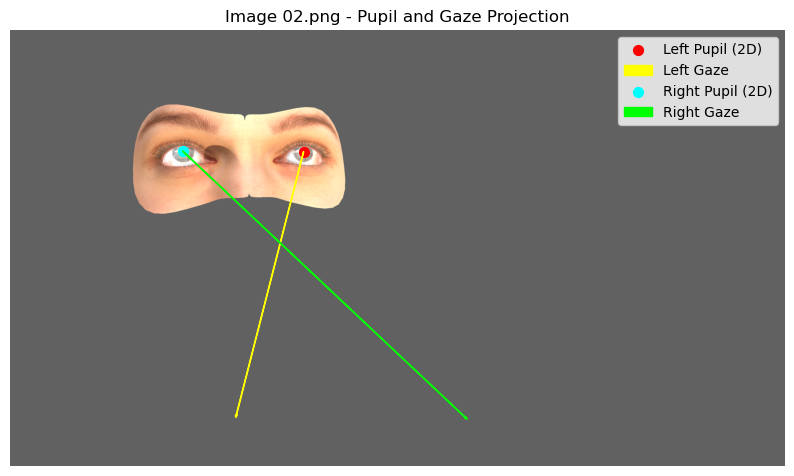

Image: 02.png
Left Pupil 3D (calibrated): [  3.1909988  -3.7882    -11.035868 ]
Headpose Gaze Vector (raw): [ 11.5513    -8.118401 -42.251   ]
Right Pupil 3D (calibrated): [ -3.2276878  -3.8293548 -11.023323 ]
-----


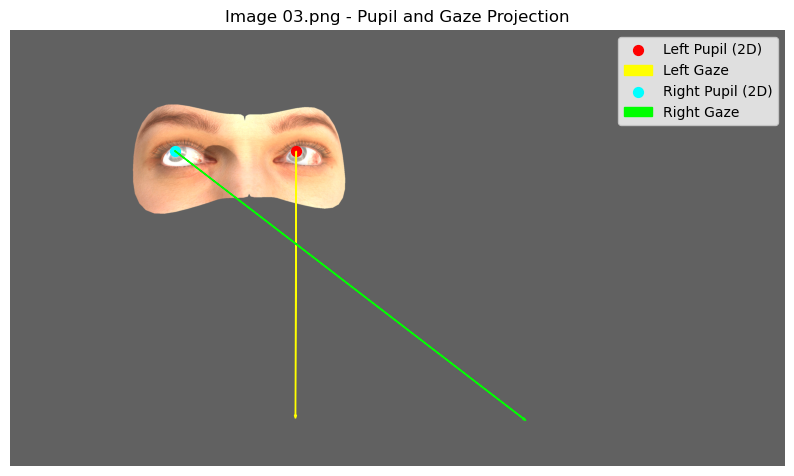

Image: 03.png
Left Pupil 3D (calibrated): [  2.7854846  -3.804499  -10.97358  ]
Headpose Gaze Vector (raw): [  0.55130005  -8.118401   -42.251     ]
Right Pupil 3D (calibrated): [ -3.6320002  -3.8504457 -10.92425  ]
-----


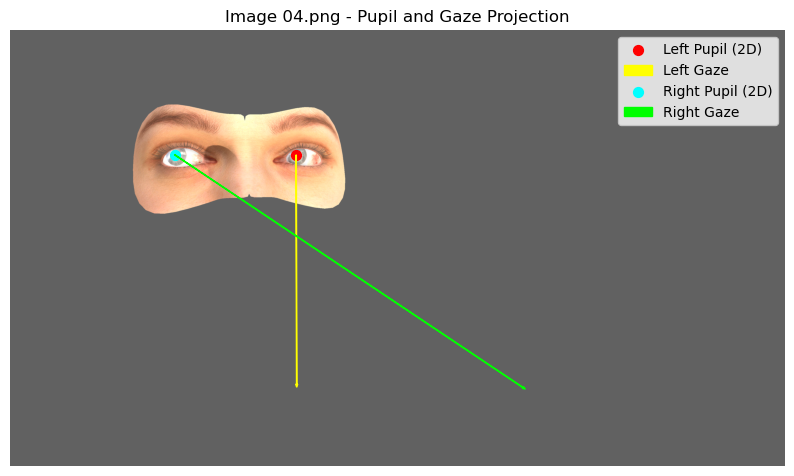

Image: 04.png
Left Pupil 3D (calibrated): [  2.769299   -3.600003  -11.0070505]
Headpose Gaze Vector (raw): [  0.55130005  -2.6184     -42.251     ]
Right Pupil 3D (calibrated): [ -3.6483004  -3.6433048 -10.966211 ]
-----


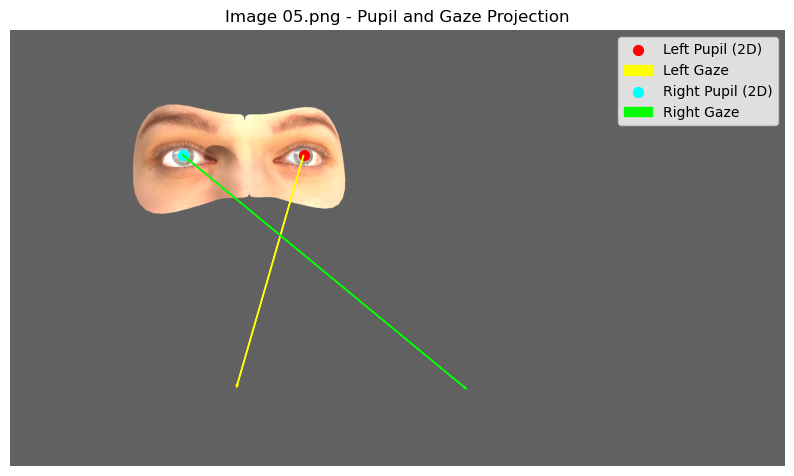

Image: 05.png
Left Pupil 3D (calibrated): [  3.179417   -3.5886738 -11.069752 ]
Headpose Gaze Vector (raw): [ 11.5513  -2.6184 -42.251 ]
Right Pupil 3D (calibrated): [ -3.237259   -3.6302207 -11.063236 ]
-----


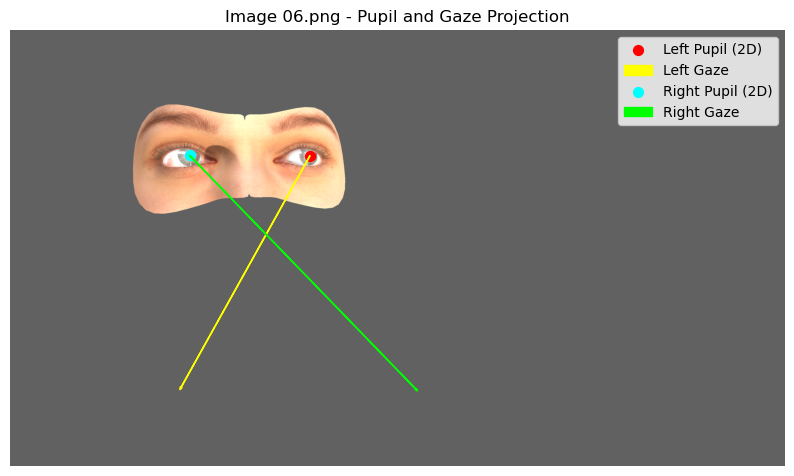

Image: 06.png
Left Pupil 3D (calibrated): [  3.5491333  -3.563644  -11.011173 ]
Headpose Gaze Vector (raw): [ 22.5513  -2.6184 -42.251 ]
Right Pupil 3D (calibrated): [ -2.8977377  -3.605255  -11.0408   ]
-----


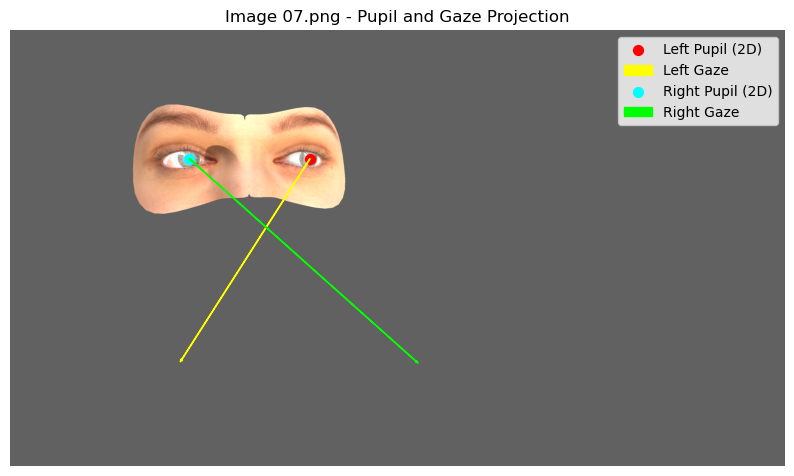

Image: 07.png
Left Pupil 3D (calibrated): [  3.537725   -3.3833613 -11.014277 ]
Headpose Gaze Vector (raw): [ 22.5513   2.8816 -42.251 ]
Right Pupil 3D (calibrated): [ -2.9112194  -3.4257705 -11.049142 ]
-----


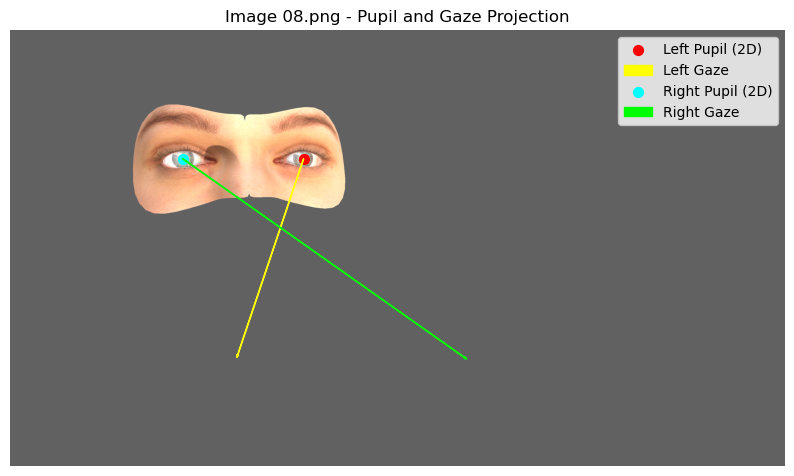

Image: 08.png
Left Pupil 3D (calibrated): [  3.1719723  -3.3857057 -11.071499 ]
Headpose Gaze Vector (raw): [ 11.5513   2.8816 -42.251 ]
Right Pupil 3D (calibrated): [ -3.2489786  -3.4263453 -11.070747 ]
-----


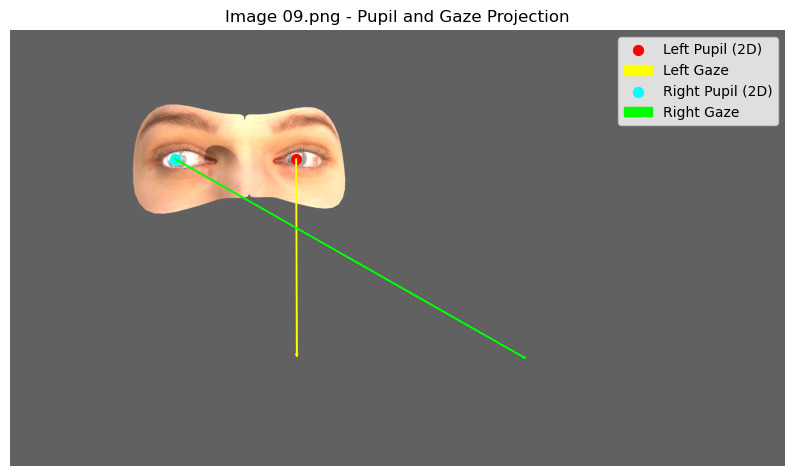

Image: 09.png
Left Pupil 3D (calibrated): [  2.7680004  -3.3918054 -11.009916 ]
Headpose Gaze Vector (raw): [  0.55130005   2.8816     -42.251     ]
Right Pupil 3D (calibrated): [ -3.6550539  -3.430365  -10.974289 ]
-----


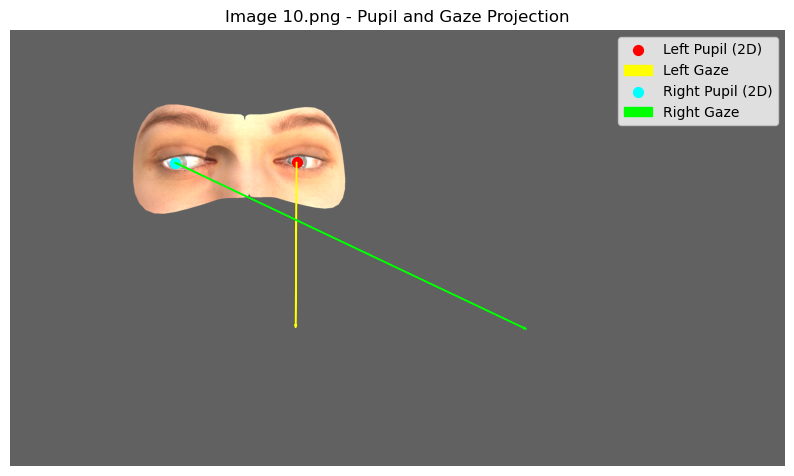

Image: 10.png
Left Pupil 3D (calibrated): [  2.7806354  -3.1955717 -10.984016 ]
Headpose Gaze Vector (raw): [  0.55130005   8.381599   -42.251     ]
Right Pupil 3D (calibrated): [ -3.6523733  -3.2295642 -10.950094 ]
-----


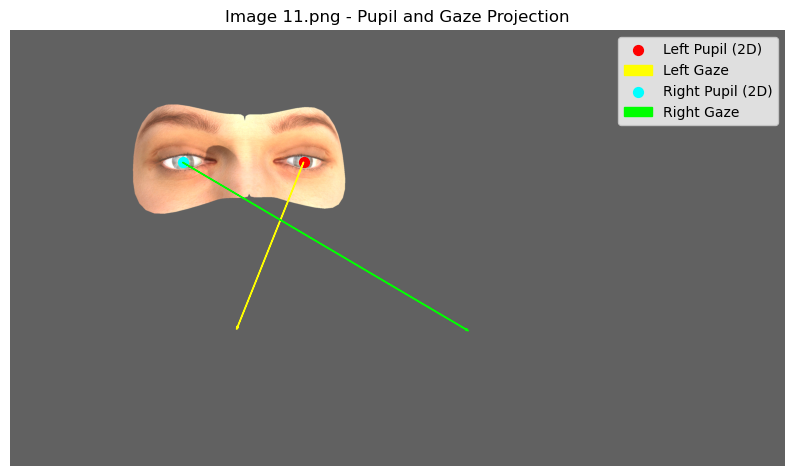

Image: 11.png
Left Pupil 3D (calibrated): [  3.1689322  -3.1943355 -11.043135 ]
Headpose Gaze Vector (raw): [ 11.5513     8.381599 -42.251   ]
Right Pupil 3D (calibrated): [ -3.2618587  -3.2330885 -11.047235 ]
-----


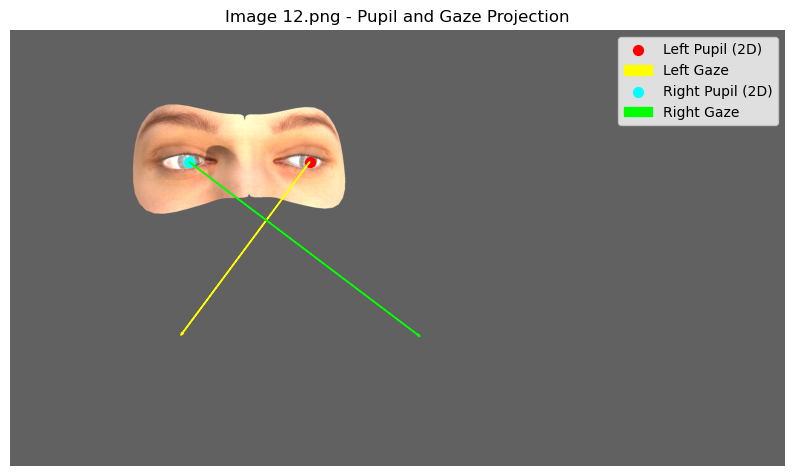

Image: 12.png
Left Pupil 3D (calibrated): [  3.522907   -3.2117903 -10.993315 ]
Headpose Gaze Vector (raw): [ 22.5513     8.381599 -42.251   ]
Right Pupil 3D (calibrated): [ -2.9318552  -3.2536597 -11.03414  ]
-----


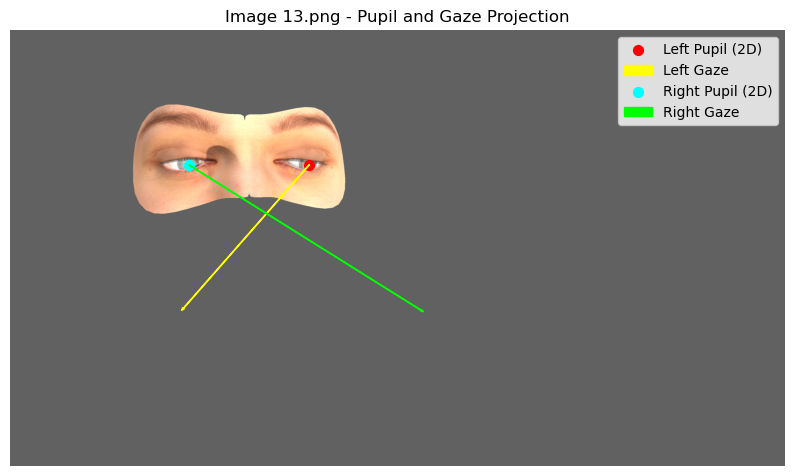

Image: 13.png
Left Pupil 3D (calibrated): [  3.5060983  -3.0572908 -10.953381 ]
Headpose Gaze Vector (raw): [ 22.5513    13.881599 -42.251   ]
Right Pupil 3D (calibrated): [ -2.9574876  -3.0971305 -10.999974 ]
-----


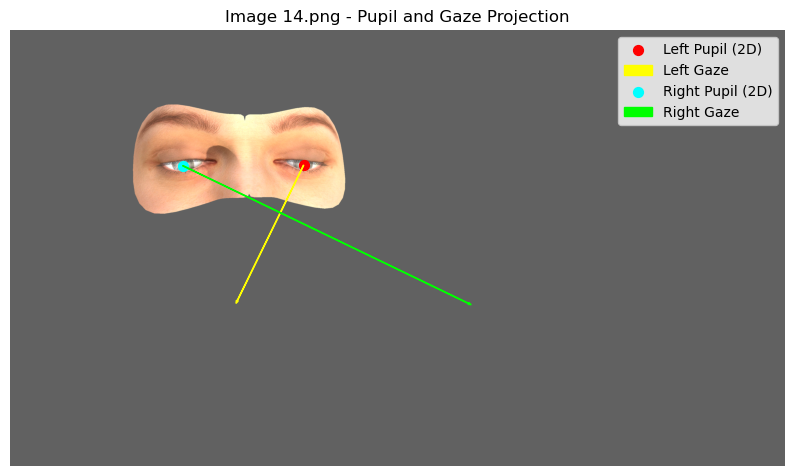

Image: 14.png
Left Pupil 3D (calibrated): [  3.1696713  -3.0254114 -10.992304 ]
Headpose Gaze Vector (raw): [ 11.5513    13.881599 -42.251   ]
Right Pupil 3D (calibrated): [ -3.2747993  -3.0618205 -11.000071 ]
-----


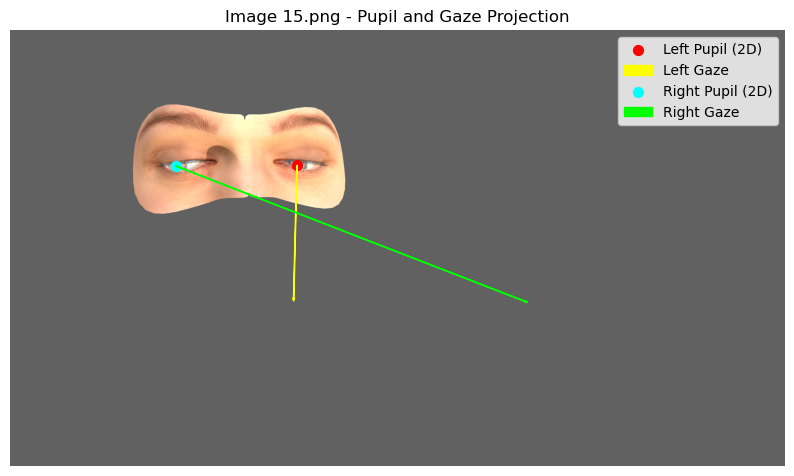

Image: 15.png
Left Pupil 3D (calibrated): [  2.803643   -3.0225842 -10.936575 ]
Headpose Gaze Vector (raw): [  0.55130005  13.881599   -42.251     ]
Right Pupil 3D (calibrated): [ -3.6424267  -3.0537376 -10.902143 ]
-----


In [5]:
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

##############################################################################
# 1) Parsing camera, user, scene
##############################################################################

def parse_camera_xml(xml_path):
    """
    Parse camera4K.xml to get resolution, focal length, etc.
    Returns:
      K:     3x3 camera intrinsic matrix
      (rx, ry): image resolution in pixels (width, height)
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Resolution
    res_elem = root.find('Resolution')
    rx = float(res_elem.find('x').text)
    ry = float(res_elem.find('y').text)

    # Focal length
    focal = float(root.find('Focal').text)

    # Principal point: assume center of image
    cx = rx / 2.0
    cy = ry / 2.0

    # Build intrinsic matrix
    K = np.array([[focal,    0, cx],
                  [   0, focal, cy],
                  [   0,    0,  1]], dtype=np.float32)
    return K, (rx, ry)

def parse_userid_xml(xml_path):
    """
    Parse userid.xml to get PCA offset and scale for user shape calibration.
    Returns:
      pca_offset: 3D offset
      pca_scale: scalar
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    pca_offset_elem = root.find('PcaOffset')
    pca_offset = np.array([
        float(pca_offset_elem.find('x').text),
        float(pca_offset_elem.find('y').text),
        float(pca_offset_elem.find('z').text)
    ], dtype=np.float32)

    pca_scale = float(root.find('PcaScale').text)
    return pca_offset, pca_scale

def parse_scene_xml(xml_path):
    """
    Parse scene.xml for additional parameters (optional).
    Returns a dict of scene parameters (e.g., SkyboxId, AmbientIntensity, etc.).
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    scene_params = {
        'SkyboxId': root.find('SkyboxId').text,
        'AmbientIntensity': float(root.find('AmbientIntensity').text)
        # Add more if needed
    }
    return scene_params

##############################################################################
# 2) Parsing headpose and POI
##############################################################################

def parse_headpose(xml_path):
    """
    Parse many_headpose.xml. Typically there's one <Headpose> element
    containing multiple <HeadposeDef> entries (one per image).
    Returns a list of dicts with keys 'position', 'lookat', 'gaze_vector'.
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    headposes = []
    headpose_node = root.find('Headpose')
    if headpose_node is None:
        return headposes  # no data?

    for def_elem in headpose_node.findall('HeadposeDef'):
        # Extract the head position and the lookAt point
        pos = def_elem.find('Position')
        look = def_elem.find('LookAtPoint')
        pos_vec = np.array([
            float(pos.find('x').text),
            float(pos.find('y').text),
            float(pos.find('z').text)
        ], dtype=np.float32)
        look_vec = np.array([
            float(look.find('x').text),
            float(look.find('y').text),
            float(look.find('z').text)
        ], dtype=np.float32)
        gaze_vec = look_vec - pos_vec

        headposes.append({
            'position': pos_vec,
            'lookat': look_vec,
            'gaze_vector': gaze_vec
        })
    return headposes

def parse_poi_left_right(xml_path):
    """
    Parse many_poi_data.xml. Typically there's a <POILeft> block and a <POIRight> block,
    each with multiple <POIDef> entries (one per image).
    Returns two lists of dicts (left_eye, right_eye), each with:
        'pupil_center_2d': (u, v)
        'pupil_center_3d': (X, Y, Z)
    If the right-eye data is missing, returns empty list for that eye.
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()

    left_data = []
    right_data = []

    # parse left
    poi_left = root.find('POILeft')
    if poi_left is not None:
        for poi_def in poi_left.findall('POIDef'):
            pc2d = poi_def.find('PupilCenter2D')
            pc3d = poi_def.find('PupilCenter3D')
            if pc2d is None or pc3d is None:
                continue
            left_data.append({
                'pupil_center_2d': np.array([
                    float(pc2d.find('x').text),
                    float(pc2d.find('y').text)
                ], dtype=np.float32),
                'pupil_center_3d': np.array([
                    float(pc3d.find('x').text),
                    float(pc3d.find('y').text),
                    float(pc3d.find('z').text)
                ], dtype=np.float32)
            })

    # parse right
    poi_right = root.find('POIRight')
    if poi_right is not None:
        for poi_def in poi_right.findall('POIDef'):
            pc2d = poi_def.find('PupilCenter2D')
            pc3d = poi_def.find('PupilCenter3D')
            if pc2d is None or pc3d is None:
                continue
            right_data.append({
                'pupil_center_2d': np.array([
                    float(pc2d.find('x').text),
                    float(pc2d.find('y').text)
                ], dtype=np.float32),
                'pupil_center_3d': np.array([
                    float(pc3d.find('x').text),
                    float(pc3d.find('y').text),
                    float(pc3d.find('z').text)
                ], dtype=np.float32)
            })

    return left_data, right_data

##############################################################################
# 3) Transform and projection
##############################################################################

def apply_extrinsic(world_point):
    """
    If the dataset uses a world coordinate system that matches the camera,
    we can just return the point as is. Otherwise, define your extrinsic matrix
    or rotation/translation here. For now, we assume identity.
    """
    # For example:
    # extrinsic_4x4 = np.eye(4, dtype=np.float32)
    # homogeneous_in = np.array([world_point[0], world_point[1], world_point[2], 1.0], dtype=np.float32)
    # camera_coords = extrinsic_4x4 @ homogeneous_in
    # return camera_coords[0:3]
    return world_point

def project_point_3d_to_2d(pt3d, K):
    """
    Pin-hole projection from camera coordinates to image 2D.
    pt3d: (Xc, Yc, Zc) in camera space
    K:    3x3 intrinsic matrix
    Returns (u, v) in pixel coords
    """
    X, Y, Z = pt3d
    # If Z is near zero or negative, the point is behind the camera
    if abs(Z) < 1e-6:
        return np.array([np.nan, np.nan], dtype=np.float32)

    fx = K[0, 0]
    fy = K[1, 1]
    cx = K[0, 2]
    cy = K[1, 2]
    u = fx * (X / Z) + cx
    v = fy * (Y / Z) + cy
    return np.array([u, v], dtype=np.float32)

##############################################################################
# 4) Main processing function
##############################################################################

def process_hp_folder(hp_folder):
    """
    In each HP_XXX folder, we have:
      many_headpose.xml (with 15 or 32 entries, one per image)
      many_poi_data.xml (with left and right eye entries, one per image)
      images: 01.png ... 15.png (or 32). We assume sorted order matches the XML order.
    """
    headpose_xml = os.path.join(hp_folder, "many_headpose.xml")
    poi_xml = os.path.join(hp_folder, "many_poi_data.xml")

    headposes = parse_headpose(headpose_xml)
    left_pois, right_pois = parse_poi_left_right(poi_xml)

    # List image files in sorted order
    image_files = sorted([f for f in os.listdir(hp_folder) if f.lower().endswith('.png')])

    # We'll assume left_pois has the same length as images (and headposes).
    # If the right eye is missing, it might have length 0 or the same length.
    assert len(image_files) == len(headposes) == len(left_pois), "Data count mismatch for left eye!"

    # It's okay if right_pois is empty or has the same length.
    # If it has the same length, we can also plot the right eye.
    if len(right_pois) not in [0, len(image_files)]:
        print("Warning: right eye data length mismatch. Will skip right eye.")
        right_pois = []

    return image_files, headposes, left_pois, right_pois

##############################################################################
# 5) Example usage
##############################################################################

if __name__ == "__main__":
    # Example directory structure
    camera_xml_path = "E:/User_01/camera4K.xml"
    userid_xml_path = "E:/User_01/userid.xml"
    scene_xml_path = "E:/User_01/Grid_15/scene.xml"

    # Parse camera intrinsics, user calibration, and scene parameters
    K, resolution = parse_camera_xml(camera_xml_path)
    pca_offset, pca_scale = parse_userid_xml(userid_xml_path)
    scene_params = parse_scene_xml(scene_xml_path)

    # Pick an HP folder, e.g. "E:/User_01/Grid_15/HP_001"
    hp_folder = "E:/User_01/Grid_15/HP_001"
    image_files, headposes, left_pois, right_pois = process_hp_folder(hp_folder)

    # We can scale the gaze vector for visualization
    gaze_scale = 5.0

    for idx, image_file in enumerate(image_files):
        img_path = os.path.join(hp_folder, image_file)
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            print(f"Could not load image {image_file}")
            continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # Headpose for this frame
        hp = headposes[idx]

        # Left eye data
        left_poi = left_pois[idx]
        # Right eye data (if available)
        right_poi = right_pois[idx] if len(right_pois) == len(image_files) else None

        # 1) Gaze vector from headpose
        gaze_vec = hp['gaze_vector']

        # 2) Left pupil center, 3D
        left_pupil_3d_raw = left_poi['pupil_center_3d']
        # Apply user calibration offset/scale
        left_pupil_3d_cal = (left_pupil_3d_raw - pca_offset) * pca_scale
        # Then transform from world -> camera (if needed)
        left_pupil_cam = apply_extrinsic(left_pupil_3d_cal)

        # 3) Build a gaze endpoint in camera coords
        #    normalized gaze + scale
        norm_gaze = gaze_vec / (np.linalg.norm(gaze_vec) + 1e-9)
        gaze_endpoint_cam = left_pupil_cam + gaze_scale * norm_gaze

        # 4) Project to 2D
        left_pupil_2d = left_poi['pupil_center_2d']  # Already in image coords from XML
        # For the 3D endpoint, we must do pinhole projection
        endpoint_2d = project_point_3d_to_2d(gaze_endpoint_cam, K)

        # 5) Plot
        plt.figure(figsize=(10, 6))
        plt.imshow(img_rgb)
        plt.scatter([left_pupil_2d[0]], [left_pupil_2d[1]],
                    c='red', s=50, label='Left Pupil (2D)')

        # Draw the arrow
        plt.arrow(left_pupil_2d[0], left_pupil_2d[1],
                  endpoint_2d[0] - left_pupil_2d[0],
                  endpoint_2d[1] - left_pupil_2d[1],
                  color='yellow', width=2, head_width=10,
                  length_includes_head=True, label='Left Gaze')

        # If right eye is available
        if right_poi is not None:
            right_pupil_3d_raw = right_poi['pupil_center_3d']
            right_pupil_3d_cal = (right_pupil_3d_raw - pca_offset) * pca_scale
            right_pupil_cam = apply_extrinsic(right_pupil_3d_cal)

            # We'll assume the same headpose gaze vector, or you might have a separate right-eye gaze?
            # If you have a separate right gaze vector, parse it from the dataset. 
            # For demonstration, let's re-use the same gaze_vec from headpose
            right_gaze_endpoint_cam = right_pupil_cam + gaze_scale * norm_gaze
            right_pupil_2d = right_poi['pupil_center_2d']
            right_endpoint_2d = project_point_3d_to_2d(right_gaze_endpoint_cam, K)

            # Plot the right pupil
            plt.scatter([right_pupil_2d[0]], [right_pupil_2d[1]],
                        c='cyan', s=50, label='Right Pupil (2D)')
            # Arrow
            plt.arrow(right_pupil_2d[0], right_pupil_2d[1],
                      right_endpoint_2d[0] - right_pupil_2d[0],
                      right_endpoint_2d[1] - right_pupil_2d[1],
                      color='lime', width=2, head_width=10,
                      length_includes_head=True, label='Right Gaze')

        plt.title(f"Image {image_file} - Pupil and Gaze Projection")
        plt.legend()
        plt.axis('off')
        plt.show()

        # For training or debugging, print out raw data
        print(f"Image: {image_file}")
        print("Left Pupil 3D (calibrated):", left_pupil_cam)
        print("Headpose Gaze Vector (raw):", gaze_vec)
        if right_poi is not None:
            print("Right Pupil 3D (calibrated):", right_pupil_cam)
        print("-----")


In [11]:
import torchvision.models as models
model = models.efficientnet_v2_m()

model.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)